# Reading values from old lcode.cfg

In [1]:
from lcode2dPy.config.default_config import default_config

In [2]:
config = default_config
path = '/home/gorn/Active/CodesMerging/beam-gen/c-test/lcode.runas.cfg'
config.update_from_c_config(path)
config.config_values

{'geometry': 'c',
 'processing-unit-type': 'cpu',
 'window-width': '4.0',
 'window-width-step-size': '0.05',
 'window-length': '30.0',
 'xi-step': '0.05',
 'time-limit': '1.0',
 'time-step': '1.0',
 'continuation': 'n',
 'plasma-particles-per-cell': '10.0',
 'rigid-beam': 'n',
 'beam-substepping-energy': '2.0',
 'focusing': 'n',
 'foc-period': '100.0',
 'foc-strength': '0.01',
 'plasma-model': 'P',
 'magnetic-field': '0.0',
 'magnetic-field-type': 'c',
 'magnetic-field-period': '200.0',
 'plasma-zshape': '',
 'plasma-temperature': '0.0',
 'ion-model': 'y',
 'ion-mass': '157000.0',
 'trapped-path-limit': '0.0',
 'noise-reductor-enabled': 'y',
 'plasma-profile': '1.0',
 'plasma-width': '2.0',
 'plasma-width-2': '1.0',
 'plasma-density-2': '0.5',
 'substepping-depth': '3.0',
 'substepping-sensitivity': '0.2',
 'field-solver-subtraction-trick': '1',
 'field-solver-variant-A': 'True',
 'reflect-padding-steps': '5',
 'plasma-padding-steps': '10',
 'corrector-steps': '2'}

# Beam generation from C-style beam profile

In [3]:
from lcode2dPy.beam_generator.beam_generator import make_beam_from_c_beam_profile

In [4]:
config = default_config
beam_profile = """
default: xishape=cos, ampl=1, length=2Pi, rshape=g, radius=1,
angshape=l, angspread=1e-5, energy=1000, vshift=0, eshape=m, espread=0, m/q=1
xishape=cos, length=1"""

make_beam_from_c_beam_profile(config, beam_profile, 1)

array([(-4.17119228e-07, 0.61896325, 1000.,  0.00918798, -0.00754985, 1., 0.01 ,    0),
       (-2.53371466e-04, 0.50917106, 1000., -0.00993385,  0.00101496, 1., 0.01 ,    1),
       (-4.61558146e-04, 1.50695356, 1000.,  0.00435568, -0.01496985, 1., 0.01 ,    2),
       ...,
       (-2.92432160e+00, 1.96291181, 1000.,  0.02650547, -0.009239  , 1., 0.005, 1988),
       (-2.92924891e+00, 1.76281563, 1000., -0.01152487,  0.0236454 , 1., 0.005, 1989),
       (-1.00000000e+05, 0.        ,    0.,  0.        ,  0.        , 1., 0.   ,    0)],
      dtype=[('xi', '<f8'), ('r', '<f8'), ('p_z', '<f8'), ('p_r', '<f8'), ('M', '<f8'), ('q_m', '<f8'), ('q_norm', '<f8'), ('id', '<i8')])

# Beam generation from C-style config

In [5]:
import numpy as np

In [6]:
from lcode2dPy.beam_generator.beam_generator import make_beam_from_c_config, particle_dtype2d

In [7]:
path = '/home/gorn/Active/CodesMerging/beam-gen/c-test/beamfile.bin'
beam_c = np.fromfile(path, dtype=particle_dtype2d)

In [8]:
path = '/home/gorn/Active/CodesMerging/beam-gen/c-test/lcode.runas.cfg'
beam_py = make_beam_from_c_config(config, path)

In [9]:
import matplotlib.pyplot as plt

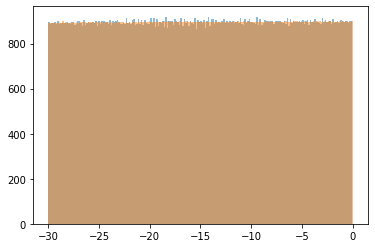

In [10]:
par = 'xi'
plt.hist(beam_c[par][:-1], 200, alpha=0.5);
plt.hist(beam_py[par][:-1], 200, alpha=0.5);

In [11]:
beam_py[-1] == beam_c[-1]

True

In [12]:
beam_c['q_m'][0] == beam_py['q_m'][0]

True

In [13]:
beam_c['q_norm'][0] == beam_py['q_norm'][0]

True

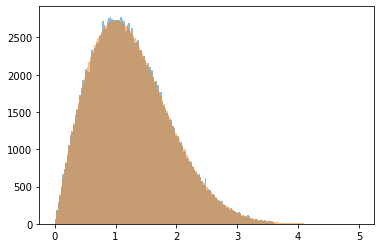

In [14]:
bins = np.linspace(0, 5, 200)
plt.hist(beam_c['r'][:-1], bins, alpha=0.5);
plt.hist(beam_py['r'][:-1], bins, alpha=0.5);

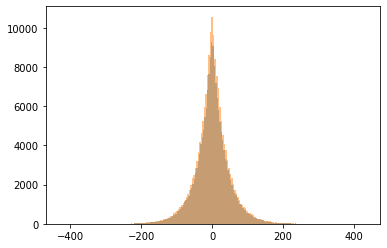

In [15]:
plt.hist(beam_c['M'][:-1], 200, alpha=0.5);
plt.hist(beam_py['M'][:-1], 200, alpha=0.5);

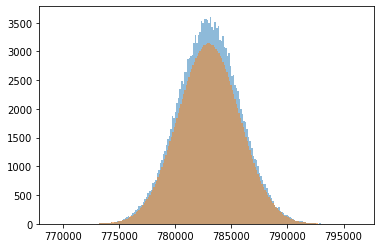

In [16]:
plt.hist(beam_c['p_z'][:-1], 200, alpha=0.5);
plt.hist(beam_py['p_z'][:-1], 200, alpha=0.5);

# Simulation test

In [1]:
from lcode2dPy.simulation.interface import Simulation
from lcode2dPy.diagnostics.targets import BeamDiagnostics
from lcode2dPy.config.default_config import default_config
from lcode2dPy.beam_generator.beam_generator import make_beam_from_c_config
import numpy as np
import matplotlib.pyplot as plt

In [5]:
path = '/home/gorn/Active/CodesMerging/beam-gen/c-test/lcode.cfg'
config = default_config
config.update_from_c_config(path)

# Diagnostics
diagnostics = [
    BeamDiagnostics(config=config, period=1)
]

beam_pars = {
    'path': path
}

sim = Simulation(config, make_beam_from_c_config, beam_pars, diagnostics)

In [6]:
sim.step(1)

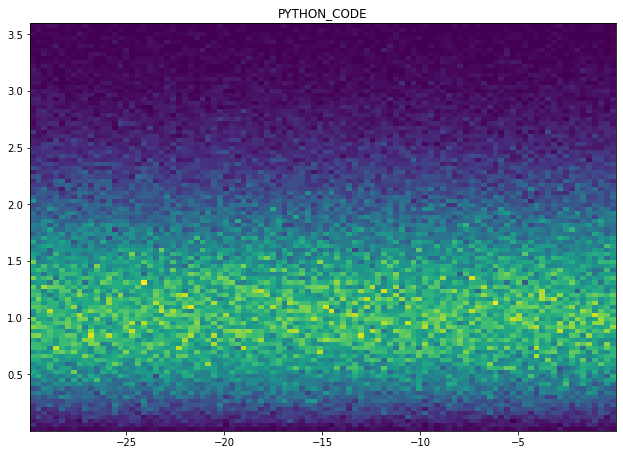

In [7]:
time_limit = config.getfloat('time-limit')
time_step = config.getfloat('time-step')
data = diagnostics[0].data
t = list(data.keys())[-1]
beam = diagnostics[0].data[t]

bins = 100
py_hist = plt.hist2d(beam['xi'], beam['r'], bins=bins)[0]
plt.title('PYTHON_CODE')

fig = plt.gcf()
fig.set_size_inches(10.5, 7.5)
plt.plot();

# Dev

In [1]:
from lcode2dPy.config.default_config import default_config
from lcode2dPy.config.config import find
from lcode2dPy.beam_generator.beam_generator import make_beam
from lcode2dPy.beam_generator.beam_profiles import SmoothDistr, StepwiseXiDistr
from copy import copy
import numpy as np
from numpy import cos, exp, pi, sqrt
from scipy import stats
import re
import pandas as pd
import os

In [3]:
def find_beam_profile_pars(cfg):
    #WORD = '[a-z][a-z]*'
    #FLOAT = '[-+]?(\d+(\.\d*)?|\.\d+)([eE][-+]?\d+)?'
    ans = re.findall('([a-z][a-z]*/?[a-z]?)\s?=\s?([-+]?(\d+(\.\d*)?|\.\d+)([eE][-+]?\d+)?|[a-z][a-z]*)', cfg)
    return ans

def find_beam_profile(cfg):
    ans = re.search('beam-profile\s?=\s?"""([^\>]*)"""', cfg)
    return ans.group(1)

default_segment_pars = {'xi0': 0,
                        'xishape': 'cos',
                        'ampl': 0.5,
                        'length': 2*np.pi,
                        'rshape': 'g',
                        'vshift': 0,
                        'radius': 1,
                        'angshape': 'l',
                        'angspread': 1e-5,
                        'energy': 1000,
                        'vshift': 0,
                        'eshape': 'm',
                        'espread': 0,
                        'm/q': 1}

def split_into_segments(beam_profile_parsed):
    xi_current = 0
    segments = []
    segment = None
    for par in beam_profile_parsed:
        par_name, par_value = par[:2]
        if par_name == 'xishape':
            if segment:
                segments.append(segment)
                xi_current = xi_current - float(segment['length'])
            segment = copy(default_segment_pars)
            segment['xi0'] = xi_current
        if par_name.find('shape') > 0:
            segment[par_name] = par_value
        else:
            segment[par_name] = float(par_value)
    segments.append(segment)
    return segments   

def get_segments_from_c_config(path):  
    with open(path, 'r') as file:
        cfg = file.read()
    beam_profile = find_beam_profile(cfg)
    beam_profile_parsed = find_beam_profile_pars(beam_profile)
    segments = split_into_segments(beam_profile_parsed)
    return segments

In [4]:
cosine = lambda x, med, L: 1./2 * (1. + np.cos(2. * np.pi * (x - med) / L))
gauss = lambda x, med, sigma: np.exp(-(x-med)**2/2./sigma**2)

xishape_to_distr = dict(
    c = lambda xi0, length, amp: StepwiseXiDistr(lambda x: cosine(x, xi0, 2*length), xi0, xi0-length, xi0, amp),
    cos = lambda xi0, length, amp: StepwiseXiDistr(lambda x: cosine(x, xi0, 2*length), xi0, xi0-length, xi0, amp),
)
rshape_to_distr = dict(
    g = lambda radius: SmoothDistr(stats.weibull_min, 0, None, 2, 0, radius),
)
angshape_to_distr = dict(
    g = lambda angspread: SmoothDistr(stats.norm, None, None, 0, angspread),
    l = lambda angspread: SmoothDistr(stats.norm, None, None, 0, angspread), # TODO
)
eshape_to_distr = dict(
    g = lambda erenergy, espread: SmoothDistr(stats.norm, None, None, erenergy, espread),
    m = lambda erenergy, espread: SmoothDistr(stats.norm, None, None, erenergy, 1e-15),
) 

def distrs_from_shapes(segment):
    distrs = dict(
        xi = xishape_to_distr[segment['xishape']](segment['xi0'], segment['length'], segment['ampl']),
        r = rshape_to_distr[segment['rshape']](segment['radius']),
        pz = eshape_to_distr[segment['eshape']](segment['energy'], segment['espread']),
        pr = angshape_to_distr[segment['angshape']](segment['angspread']),
        pf = angshape_to_distr[segment['angshape']](segment['angspread']),
    )
    return distrs

In [5]:
def make_beam_from_c_config(path, partic_in_layer=None, savehead=False, saveto=False, name='beamfile.bin'):
    if partic_in_layer is None:
        with open(path, 'r') as file:
            cfg = file.read()
        partic_in_layer = find(cfg, 'beam-particles-in-layer')
        partic_in_layer = int(partic_in_layer)
    segments = get_segments_from_c_config(path)
    beam = None
    for i, segment in enumerate(segments):
        new_beam = make_beam(config, distrs_from_shapes(segment), 
                             q_m=1/segment['m/q'], identifier=i, 
                             partic_in_layer=partic_in_layer)
        if beam is None:
            beam = new_beam
        else:
            beam = beam[:-1].append(new_beam, ignore_index=True)
    beam.sort_values('xi', inplace=True, ascending=False)
    
    ##### saving data ######
    head = beam[beam.eval('xi>0')]
    beam = beam[beam.eval('xi<=0')]
    if saveto:
        beam.values.tofile(os.path.join(saveto, name))
    if savehead:
        head.values.tofile(os.path.join(saveto, 'head-' + name))
    return beam

In [6]:
path = '/home/gorn/work/Tests/lcode-test/lcode.runas.cfg'
make_beam_from_c_config(path)

,xi,r,pz,pr,M,q_m,q,id
0,-0.000335,1.084503,1000.0,-0.000004,2.697555e-07,1.0,0.010,0
1,-0.000353,1.133317,1000.0,-0.000005,-2.026643e-06,1.0,0.010,1
2,-0.000618,0.313655,1000.0,-0.000005,-5.910181e-07,1.0,0.010,2
3,-0.000890,1.992938,1000.0,-0.000032,-2.358334e-06,1.0,0.010,3
4,-0.001070,0.801534,1000.0,0.000012,-6.297531e-06,1.0,0.010,4
...,...,...,...,...,...,...,...,...
5966,-2.894226,0.260884,1000.0,0.000004,3.342870e-07,1.0,0.005,1000000001986
5967,-2.894381,0.482817,1000.0,0.000003,6.461324e-06,1.0,0.005,1000000001987
5968,-2.905454,0.370207,1000.0,-0.000003,-1.109346e-06,1.0,0.005,1000000001988
5969,-2.930551,0.661724,1000.0,-0.000003,-1.401698e-05,1.0,0.005,1000000001989
